In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as sns
sns.set_style('ticks', {'axes.grid': True})
sns.set_context('poster', font_scale=2.0)
%config InlineBackend.figure_format = 'retina'

plt.rcParams['figure.figsize'] = (12.8, 9.6)
plt.rcParams['figure.facecolor'] = 'white'


In [3]:
import pickle
import os

In [4]:
from matplotlib.ticker import MultipleLocator

In [5]:
import scipy

import scipy.constants as sc
hbarc = ( sc.hbar * sc.speed_of_light
         / sc.mega / sc.electron_volt / sc.femto )
ainv = 2.194e3 # lattice cutoff in GeV
lat_unit = hbarc/ainv # lattice spacing in fm

mxi = 0.665 # mass of Xi in lattice unit
mpi = 510/ainv # mass of pion in lattice unit
m_red = 0.5 * mxi # reduced mass

In [6]:
bin_num = 20 # number of jackknife samples

In [7]:
# uncertainties is a useful python library to calculate the propagation of the errors
# pip install uncertainties 
from uncertainties import ufloat

In [8]:
print(np.__version__)
print(scipy.__version__)
print(sns.__version__)
print(matplotlib.__version__)

1.14.2
1.0.0
0.8.1
2.2.2


# import data

In [9]:
its = [13, 14, 15, 16]

In [10]:
eigenvals = {}
eigenfuncs_compressed = {}

In [11]:
L = 40
for it in its:
    with open('../data/eigen/eigenfuncs.40.t{}.nev50.pkl'.format(it), 'rb') as fin:
        eigenvals[(L,it)], eigenfuncs_compressed[(L,it)] = pickle.load(fin)

In [12]:
L = 48
for it in its:
    with open('../data/eigen/eigenfuncs.48.t{}.nev75.pkl'.format(it), 'rb') as fin:
        eigenvals[(L,it)], eigenfuncs_compressed[(L,it)] = pickle.load(fin)

In [13]:
L = 64
for it in its:
    with open('../data/eigen/eigenfuncs.64.t{}.nev100.pkl'.format(it), 'rb') as fin:
        eigenvals[(L,it)], eigenfuncs_compressed[(L,it)] = pickle.load(fin)

In [14]:
conv_rela = lambda E: 2.0*np.sqrt(mxi*E + mxi**2) - 2.0*mxi
for key in eigenvals.keys():
    eigenvals[key] = conv_rela(eigenvals[key])

In [15]:
eigenval_avs = {}
eigenval_errs = {}
for it in its:
    eigenval_avs[it] = {L: eigenvals[(L,it)].mean(axis=0)
                       for L in [40, 48, 64]}
    eigenval_errs[it] = {L: eigenvals[(L,it)].std(axis=0)*np.sqrt(bin_num - 1)
                        for L in [40, 48, 64]}
    
mode_num = {40: 5, 48: 6, 64: 7}

In [16]:
Rcorr_jk_compressed = {}

In [17]:
for L in [40, 48, 64]:
    for it in its:
        for src in ['wall', 'exp']:
            with open(f'../data/Rcorr/Rcorr_xixi_1s0_L{L}_t{it:03d}_{src}_20jkbins.pkl', 'rb') as fin:
                Rcorr_jk_compressed[(src, L, it)] = pickle.load(fin)

In [18]:
Rcorr_jk_compressed[('wall', 48, 13)].shape

(20, 2925)

# decompress wavefunc.

In [19]:
Rcorr_jk = {}
eigenfuncs = {}

In [20]:
Rcorr_jk_compressed.keys()

dict_keys([('wall', 40, 13), ('exp', 40, 13), ('wall', 40, 14), ('exp', 40, 14), ('wall', 40, 15), ('exp', 40, 15), ('wall', 40, 16), ('exp', 40, 16), ('wall', 48, 13), ('exp', 48, 13), ('wall', 48, 14), ('exp', 48, 14), ('wall', 48, 15), ('exp', 48, 15), ('wall', 48, 16), ('exp', 48, 16), ('wall', 64, 13), ('exp', 64, 13), ('wall', 64, 14), ('exp', 64, 14), ('wall', 64, 15), ('exp', 64, 15), ('wall', 64, 16), ('exp', 64, 16)])

In [21]:
Rcorr_jk_compressed[('wall', 48, 13)].shape

(20, 2925)

In [22]:
eigenfuncs_compressed.keys()

dict_keys([(40, 13), (40, 14), (40, 15), (40, 16), (48, 13), (48, 14), (48, 15), (48, 16), (64, 13), (64, 14), (64, 15), (64, 16)])

In [23]:
eigenfuncs_compressed[(48, 13)].shape

(20, 2925, 6)

In [24]:
def gen_xyz_index(L):
    a1_uniq = np.array([ix + L * (iy + L * iz)
                       for ix in range(0, L//2+1)
                       for iy in range(0, ix+1)
                       for iz in range(0, iy+1)])
    a1_uniq_ind = {}
    ind = 0
    for ix in range(0, L//2+1):
        for iy in range(0, ix+1):
            for iz in range(0, iy+1):
                a1_uniq_ind[(ix, iy, iz)] = ind
                ind += 1
    xyz_ind = {}
    for ix in range(L):
        for iy in range(L):
            for iz in range(L):
                _ind = np.sort([min(ix,L-ix), min(iy,L-iy), min(iz,L-iz)])[::-1]
                xyz_ind[(ix,iy,iz)] = a1_uniq_ind[(_ind[0], _ind[1], _ind[2])]
    return xyz_ind

In [25]:
L = 40
xyz_ind = gen_xyz_index(L)
for src in ['wall', 'exp']:
    for it in its:
        wave_full = np.zeros((bin_num, L, L, L))
        for ix in range(L):
            for iy in range(L):
                for iz in range(L):
                    wave_full[:,ix,iy,iz] = Rcorr_jk_compressed[(src, L, it)][:,xyz_ind[(ix,iy,iz)]]
        Rcorr_jk[(src,L,it)] = wave_full.reshape(bin_num, L**3)

it0 = 13
nmodes = eigenfuncs_compressed[(L, it0)].shape[2]
for it in its:
    wave_full = np.zeros((bin_num, L, L, L, nmodes))
    for ix in range(L):
        for iy in range(L):
            for iz in range(L):
                wave_full[:,ix,iy,iz,:] = eigenfuncs_compressed[(L, it)][:,xyz_ind[(ix,iy,iz)],:]
    eigenfuncs[(L,it)] = wave_full.reshape(bin_num, L**3, nmodes)

In [26]:
L = 48
xyz_ind = gen_xyz_index(L)
for src in ['wall', 'exp']:
    for it in its:
        wave_full = np.zeros((bin_num, L, L, L))
        for ix in range(L):
            for iy in range(L):
                for iz in range(L):
                    wave_full[:,ix,iy,iz] = Rcorr_jk_compressed[(src, L, it)][:,xyz_ind[(ix,iy,iz)]]
        Rcorr_jk[(src,L,it)] = wave_full.reshape(bin_num, L**3)

it0 = 13
nmodes = eigenfuncs_compressed[(L, it0)].shape[2]
for it in its:
    wave_full = np.zeros((bin_num, L, L, L, nmodes))
    for ix in range(L):
        for iy in range(L):
            for iz in range(L):
                wave_full[:,ix,iy,iz,:] = eigenfuncs_compressed[(L, it)][:,xyz_ind[(ix,iy,iz)],:]
    eigenfuncs[(L,it)] = wave_full.reshape(bin_num, L**3, nmodes)

In [27]:
L = 64
xyz_ind = gen_xyz_index(L)
for src in ['wall', 'exp']:
    for it in its:
        wave_full = np.zeros((bin_num, L, L, L))
        for ix in range(L):
            for iy in range(L):
                for iz in range(L):
                    wave_full[:,ix,iy,iz] = Rcorr_jk_compressed[(src, L, it)][:,xyz_ind[(ix,iy,iz)]]
        Rcorr_jk[(src,L,it)] = wave_full.reshape(bin_num, L**3)

it0 = 13
nmodes = eigenfuncs_compressed[(L, it0)].shape[2]
for it in its:
    wave_full = np.zeros((bin_num, L, L, L, nmodes))
    for ix in range(L):
        for iy in range(L):
            for iz in range(L):
                wave_full[:,ix,iy,iz,:] = eigenfuncs_compressed[(L, it)][:,xyz_ind[(ix,iy,iz)],:]
    eigenfuncs[(L,it)] = wave_full.reshape(bin_num, L**3, nmodes)

In [28]:
Rcorr_jk[('wall',64,13)].shape

(20, 262144)

# overlap factors

definition of fators

\begin{equation}
a_n \equiv \exp(\Delta E_n t) \sum \Psi_n(r) R(r,t), 
\quad b_n \equiv a_n \sum \Psi_n
\end{equation}

In [29]:
def eval_contaminations(L, src, it):
    a_n_jk = []
    b_n_jk = []
    sum_psi_n_jk = []
    for nth in range(eigenvals[(L,it)].shape[1]):
        _an = np.array([
            np.exp(eigenvals[L,it][ibin,nth]*it) * eigenfuncs[(L,it)][ibin,:,nth].dot(Rcorr_jk[(src,L,it)][ibin,:])
            for ibin in range(bin_num)])
        
        a_n_jk.append(_an)
        _sum_psi = np.array([np.sum(eigenfuncs[(L,it)][ibin,:,nth]) for ibin in range(bin_num)])
        b_n_jk.append(_an * _sum_psi)
        sum_psi_n_jk.append(_sum_psi)
    return np.array(a_n_jk), np.array(b_n_jk), np.array(sum_psi_n_jk)

In [30]:
an_jk = {}
bn_jk = {}
sum_psi_n_jk = {}
for it in its:
    for src in ['wall', 'exp']:
        for L in [40, 48, 64]:
            an_jk[(src,L,it)], bn_jk[(src,L,it)], sum_psi_n_jk[(src,L,it)] = eval_contaminations(L, src, it)

In [31]:
mkdir -p pickles

In [32]:
with open('pickles/an_bn_and_eigen.pkl', 'wb') as fout:
    pickle.dump((an_jk, bn_jk, eigenvals), fout)

In [33]:
with open('pickles/an_bn_and_eigen.pkl', 'rb') as fin:
    an_jk, bn_jk, eigenvals = pickle.load(fin)

In [34]:
mkdir -p ../figs/factors

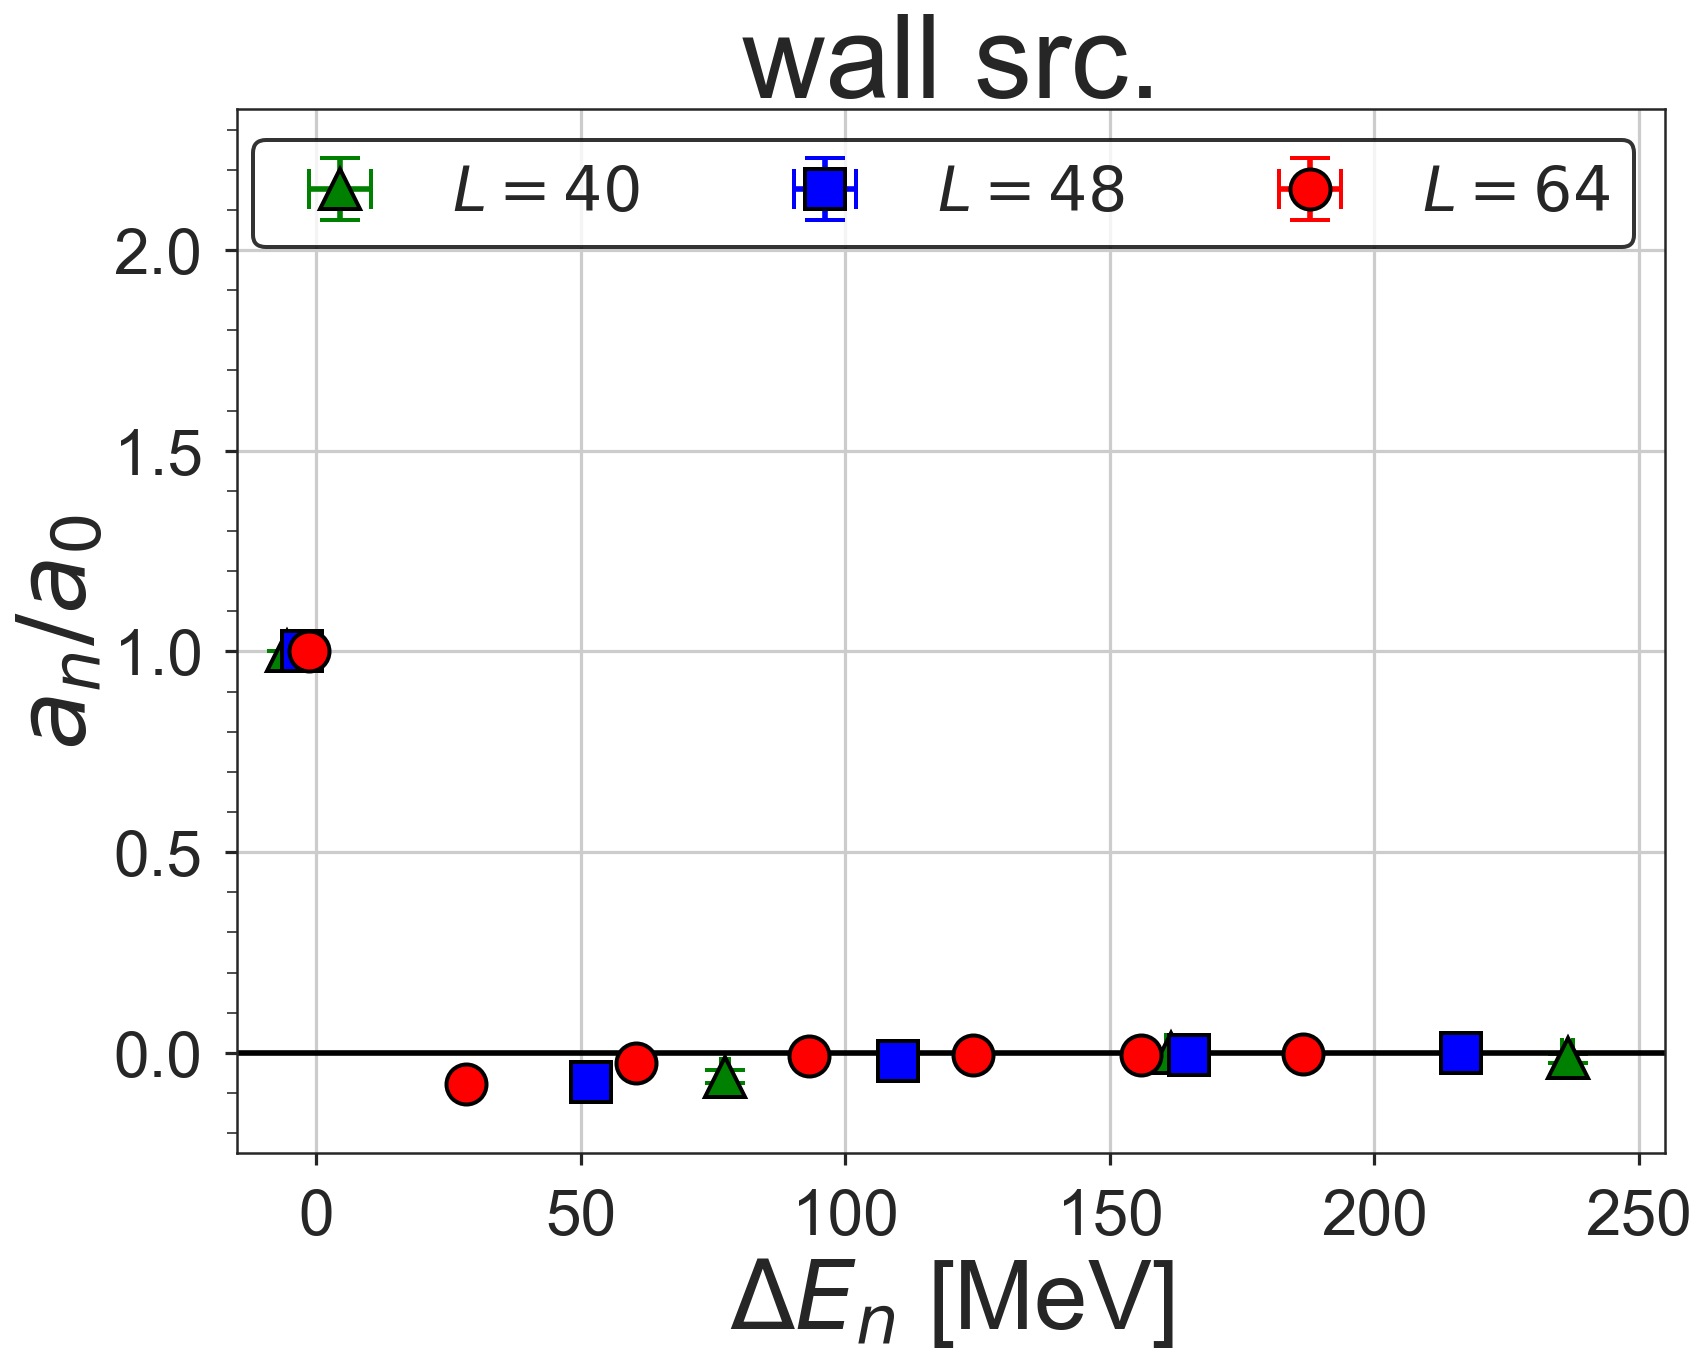

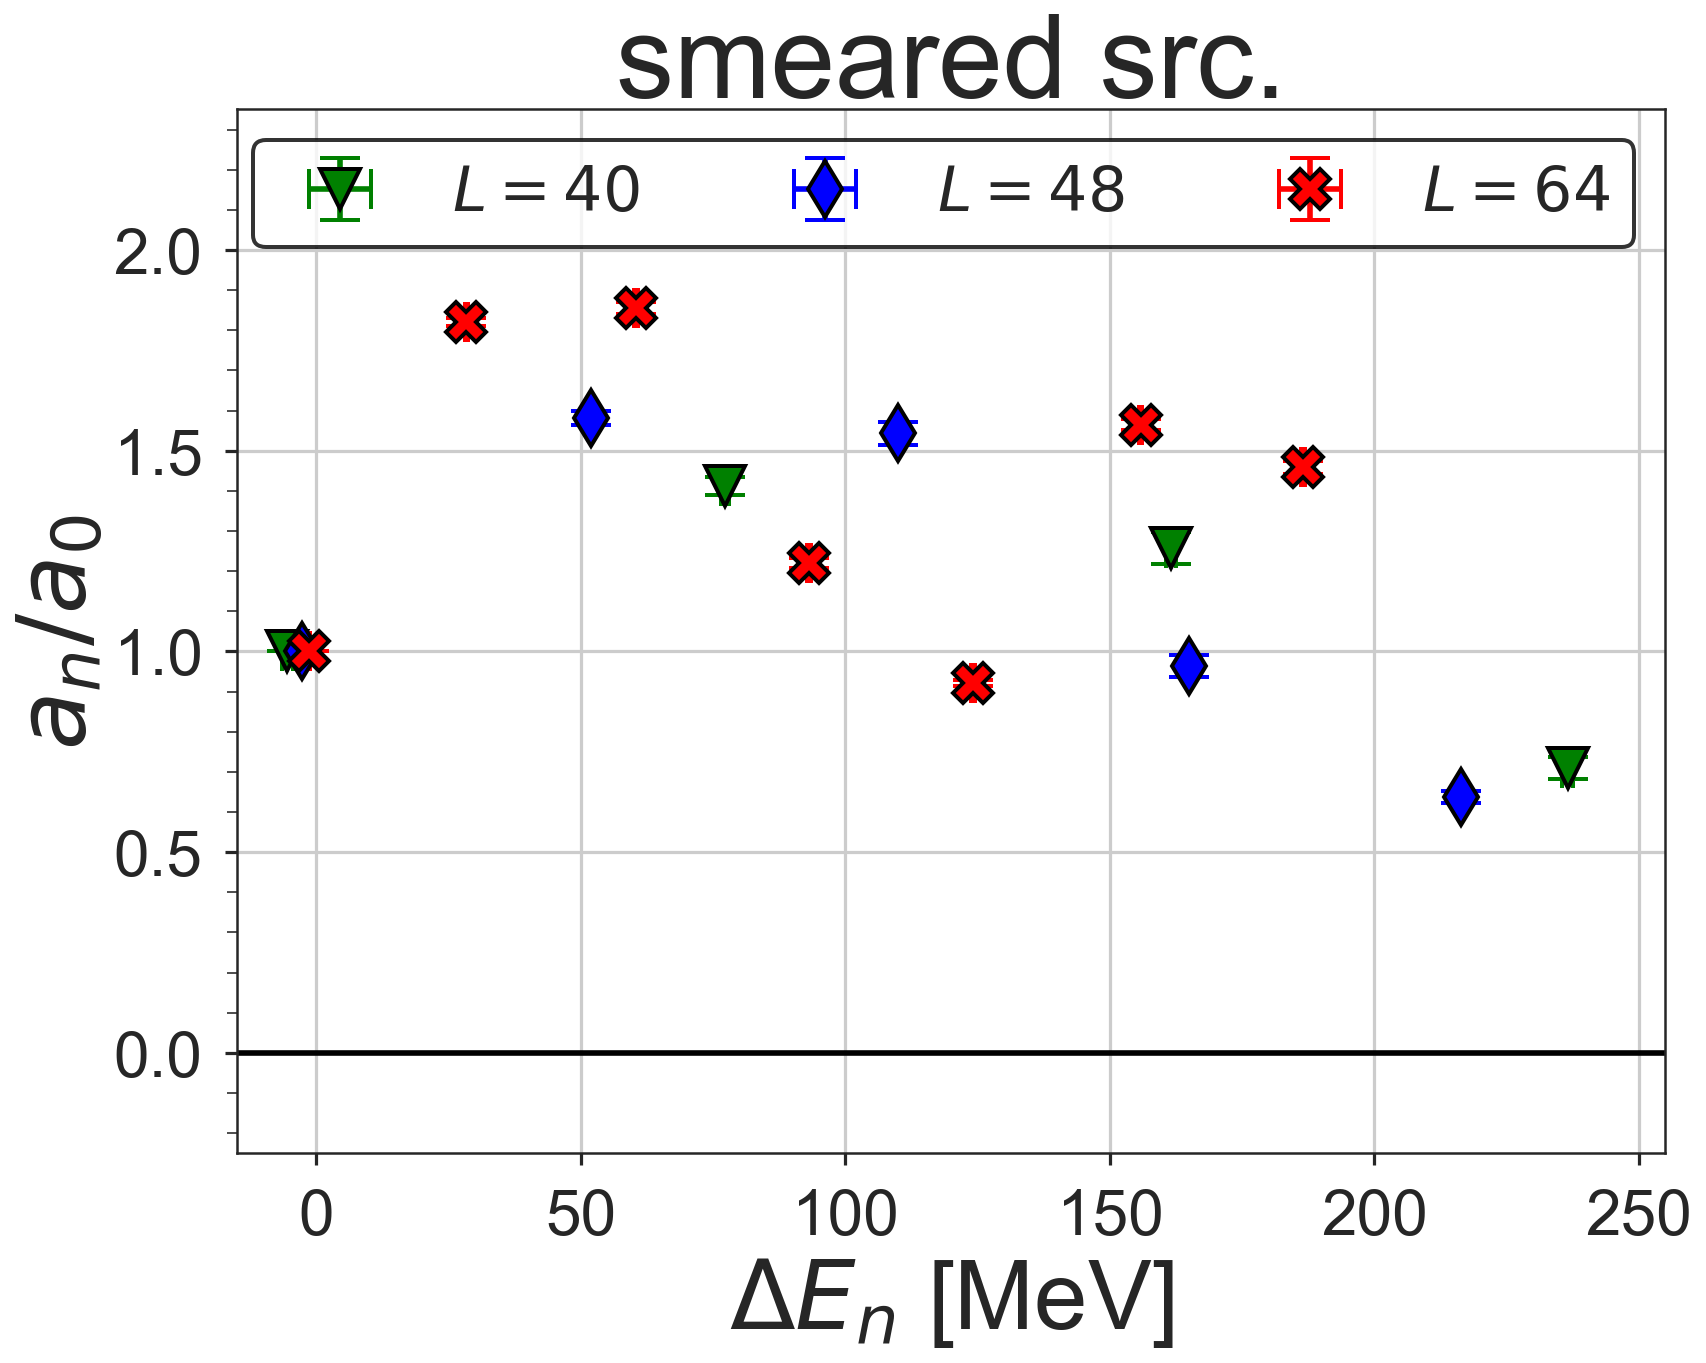

In [35]:
for src in  ['wall', 'exp']:
    for it in [13]:
        fig, ax = plt.subplots()
        syms = {'wall': ['^', 's', 'o'], 'exp': ['v', 'd', 'X']}[src]
        colors = ['green', 'blue', 'red']
        for L, fmt, col in zip([40, 48, 64], syms, colors):
            an = an_jk[(src,L,it)]
            an_a0 = an[:,:]/an[0,:]
            ax.errorbar(eigenval_avs[it][L]*ainv, an_a0.mean(axis=1), an_a0.std(axis=1) * np.sqrt(bin_num - 1),
                       xerr=eigenval_errs[it][L]*ainv, fmt=fmt, ms=20, color=col, mew=2.0, mec='black',
                        capthick=2.0, capsize=10,
                       label=r'$L = {}$'.format(L))

        leg = ax.legend(ncol=3, loc='upper right', frameon=True, fontsize=31)
        leg.get_frame().set_edgecolor('black')
        leg.get_frame().set_linewidth(2.0)
        ax.set_xlabel(r'$\Delta E_n$ [MeV]', size=48)
        ax.set_ylabel(r'$a_n/a_0$', size=48)
        ax.set_xlim(-15, 255)
        ax.set_title({'wall': 'wall src.', 'exp':'smeared src.'}[src], size=58)
        ax.axhline(0, color='black')
        ax.set_ylim(-0.25, 2.35)
        ax.yaxis.set_minor_locator(MultipleLocator(0.1))
        ax.tick_params(which='minor', length=5)
        fig.savefig('../figs/factors/an_a0_{}_t{:03d}.pdf'.format(src, it), 
                   bbox_inches='tight')

In [36]:
rs_ = {}
for L in [40, 48, 64]:
    tmp = np.array([np.sqrt(ix**2+iy**2+iz**2)
                   for ix in range(-L//2,L//2)
                   for iy in range(-L//2,L//2)
                   for iz in range(-L//2,L//2)]).reshape(L,L,L)
    rs_[L] = np.roll(np.roll(np.roll(tmp, L//2,0), L//2, 1), L//2, 2).flatten()

In [37]:
uniq_a1_ = {}
for L in [40, 48, 64]:
    uniq_a1_[L] = np.array([ix + L*(iy + L*iz)
                           for ix in range(0,L//2+1)
                           for iy in range(0,ix+1)
                           for iz in range(0,iy+1)])

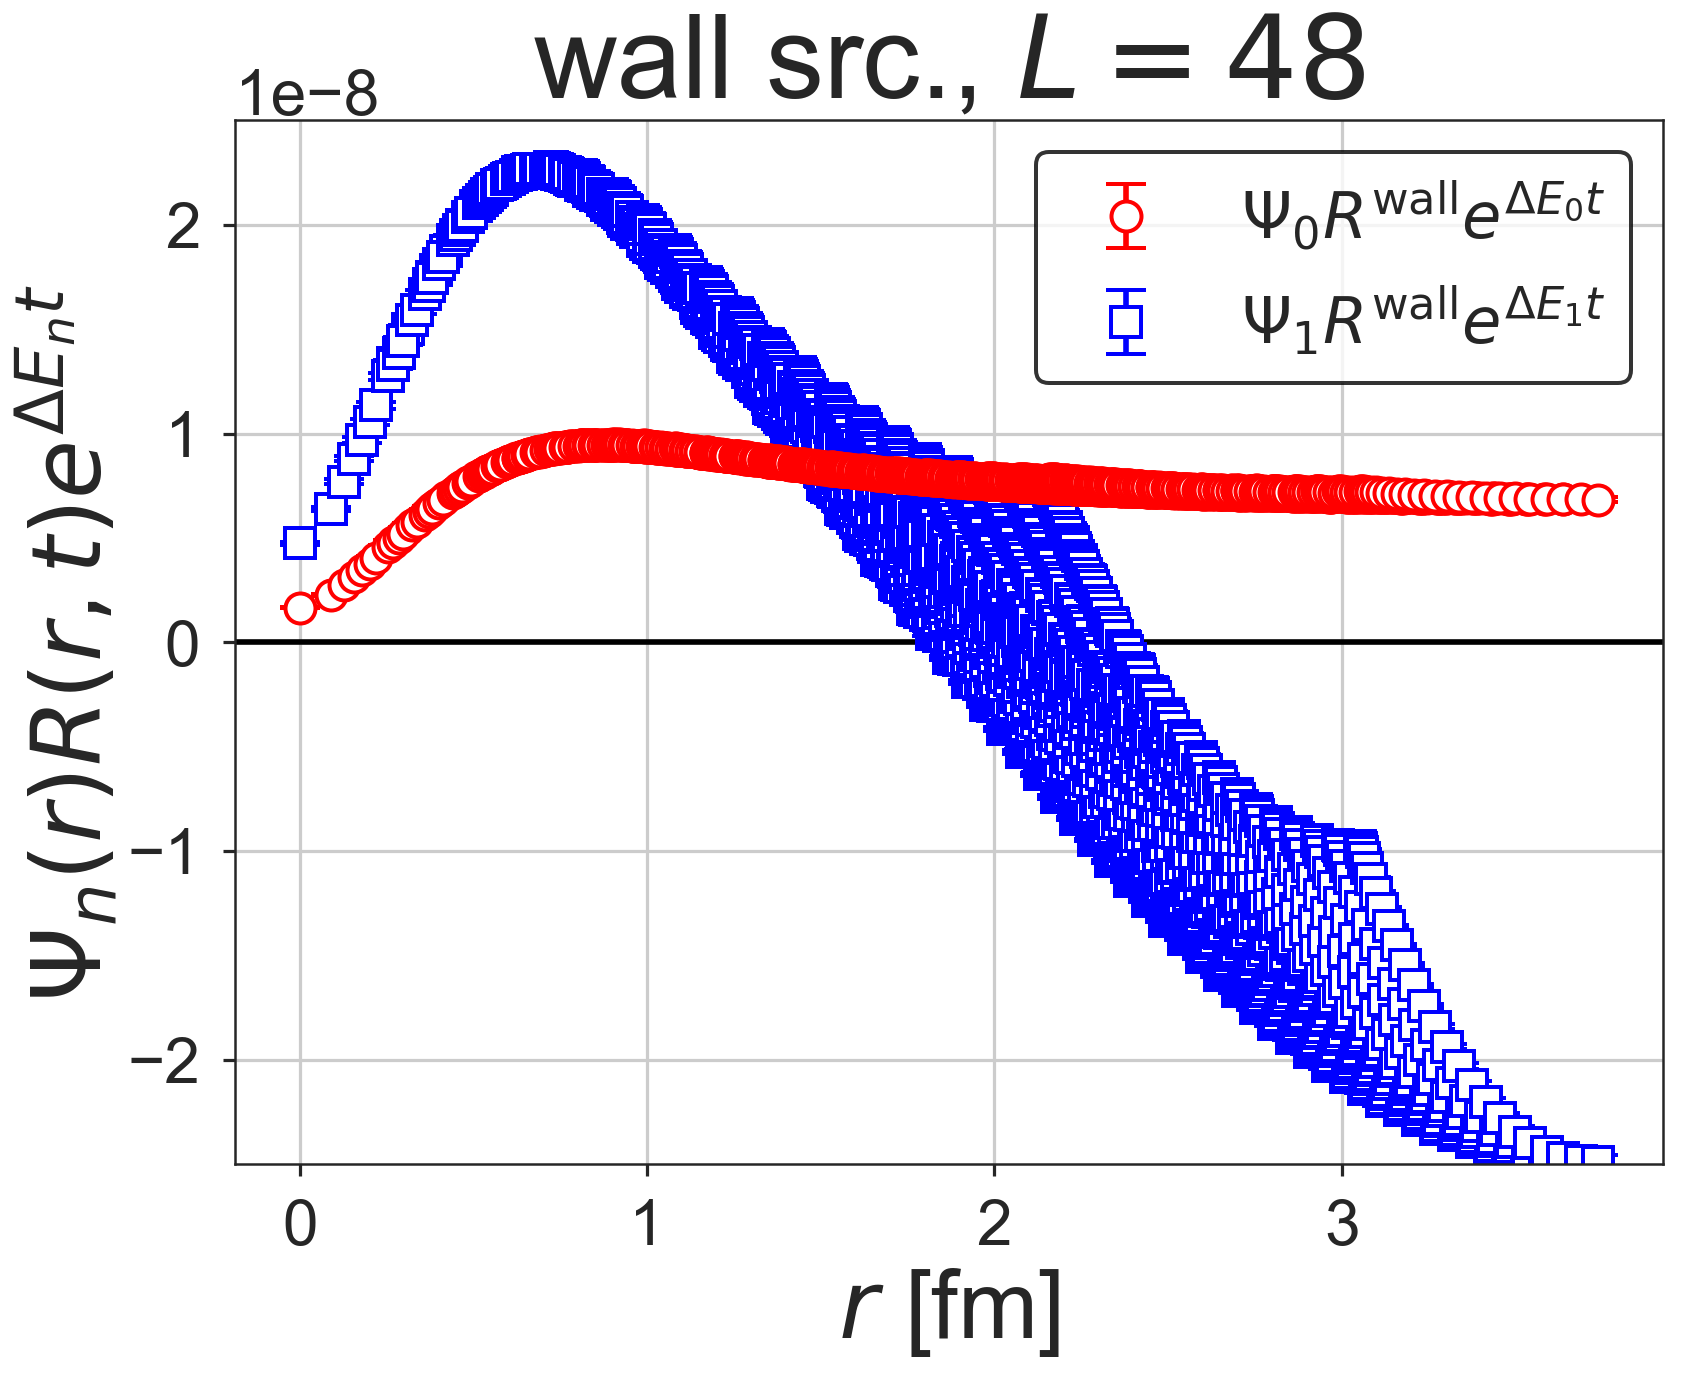

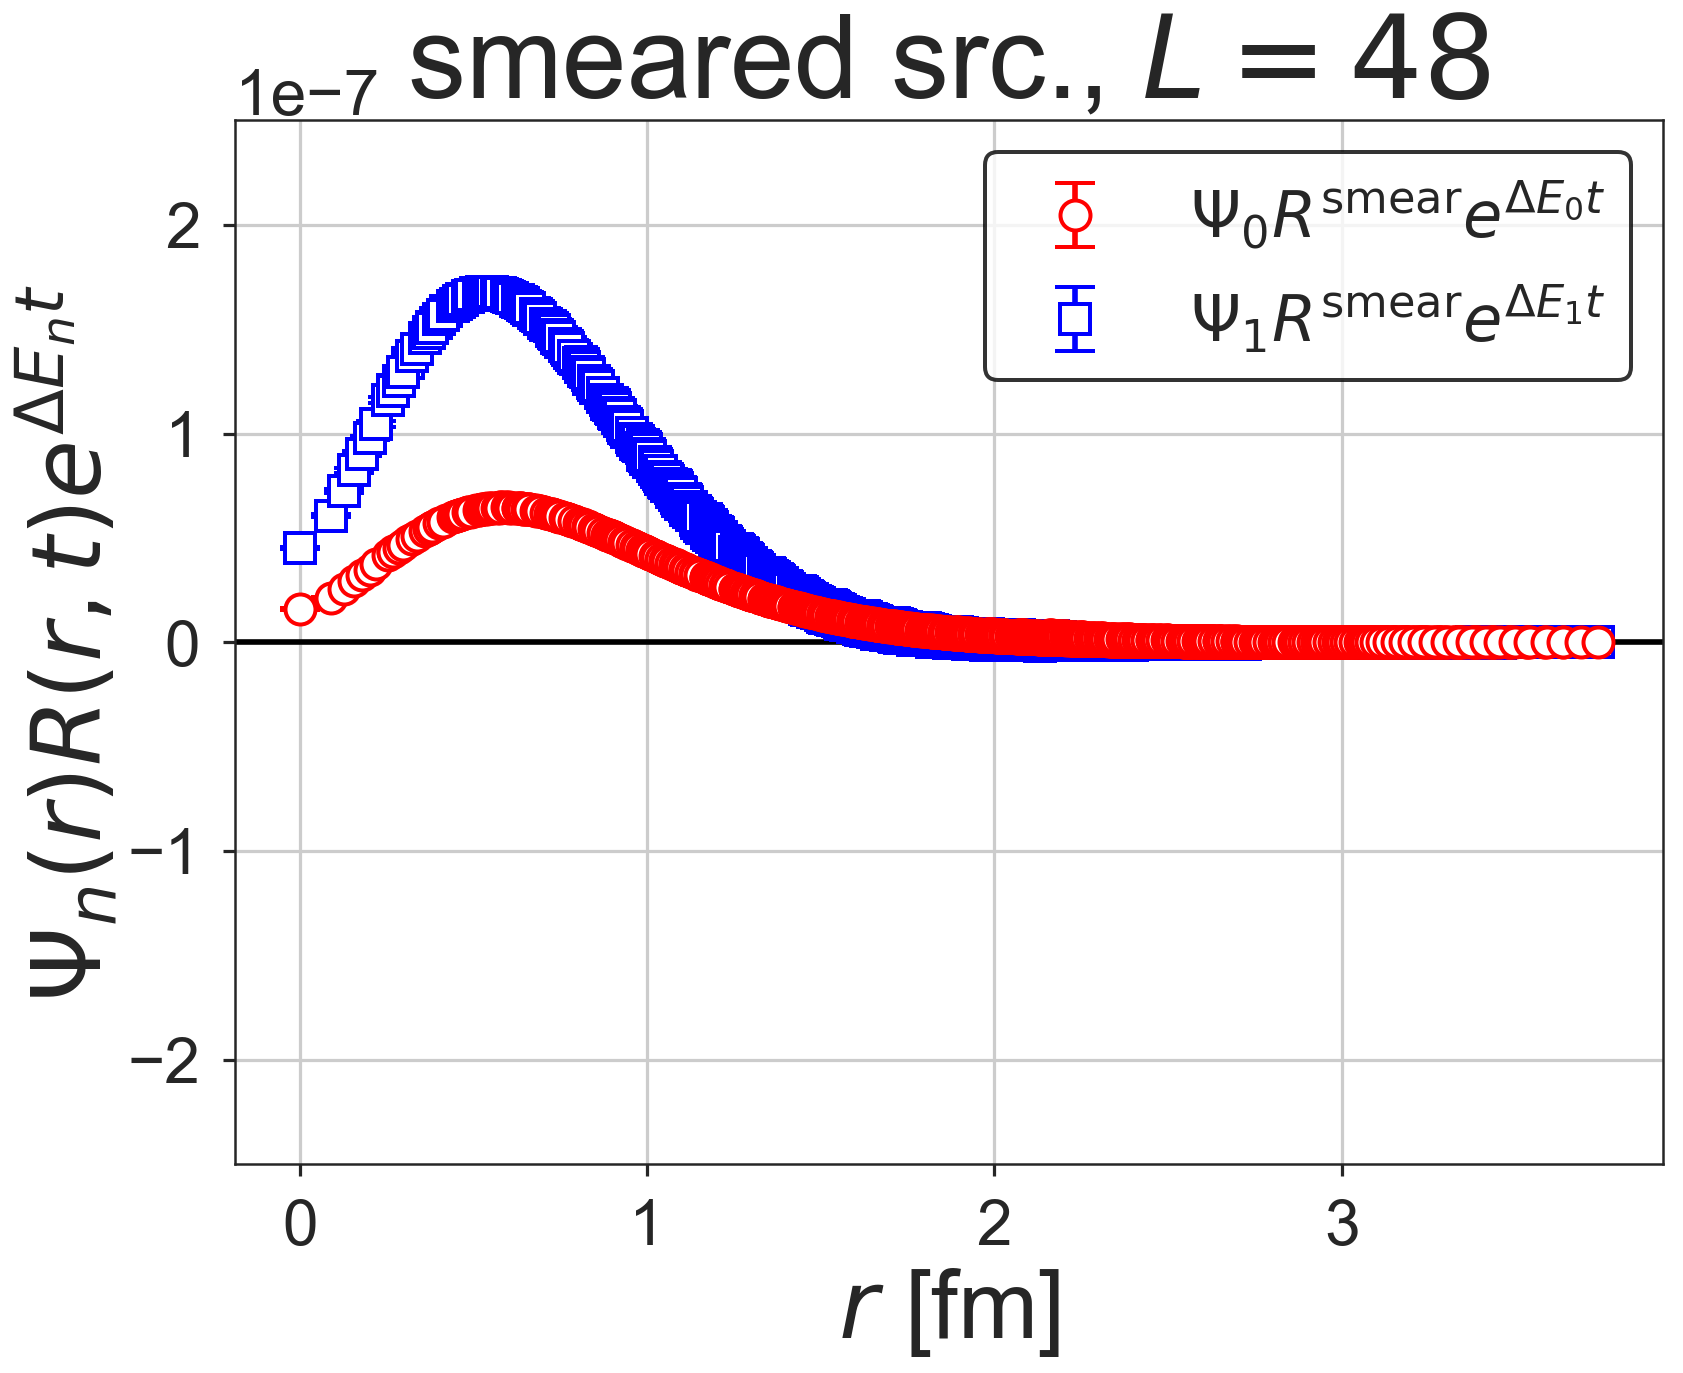

In [38]:
for src, cols in zip(['wall', 'exp'], [['red', 'blue'], ['red', 'blue']]):
    L = 48
    it = 13

    tmp_gs = eigenfuncs[(L,it)][:,:,0] * Rcorr_jk[(src,L,it)] * np.exp(eigenvals[(L,it)][:,0,np.newaxis]*it)
    tmp_1st = eigenfuncs[(L,it)][:,:,1] * Rcorr_jk[(src,L,it)] * np.exp(eigenvals[(L,it)][:,1,np.newaxis]*it)

    fig, ax = plt.subplots()
    if src == 'wall':
        ax.errorbar(rs_[L][uniq_a1_[L]]*lat_unit,
                   tmp_1st.mean(axis=0)[uniq_a1_[L]], tmp_1st.std(axis=0)[uniq_a1_[L]] * np.sqrt(bin_num - 1), 
                    capthick=2.0, capsize=10, ms=15,
                    fmt='s', color=cols[1], mfc='white', mec=cols[1], mew=2.0, label=r'$\Psi_1R^{\mathrm{wall}}e^{\Delta E_1t}$')
        ax.errorbar(rs_[L][uniq_a1_[L]]*lat_unit,
                   tmp_gs.mean(axis=0)[uniq_a1_[L]], tmp_gs.std(axis=0)[uniq_a1_[L]] * np.sqrt(bin_num - 1), 
                    capthick=2.0, capsize=10, ms=15,
                    fmt='o', color=cols[0], mfc='white', mec=cols[0], mew=2.0, label=r'$\Psi_0R^{\mathrm{wall}}e^{\Delta E_0t}$')
    else:
        ax.errorbar(rs_[L][uniq_a1_[L]]*lat_unit,
                   tmp_1st.mean(axis=0)[uniq_a1_[L]], tmp_1st.std(axis=0)[uniq_a1_[L]] * np.sqrt(bin_num - 1), 
                    capthick=2.0, capsize=10, ms=15,
                    fmt='s', color=cols[1], mfc='white', mec=cols[1], mew=2.0, label=r'$\Psi_1R^{\mathrm{smear}}e^{\Delta E_1t}$')
        ax.errorbar(rs_[L][uniq_a1_[L]]*lat_unit,
                   tmp_gs.mean(axis=0)[uniq_a1_[L]], tmp_gs.std(axis=0)[uniq_a1_[L]] * np.sqrt(bin_num - 1), 
                    capthick=2.0, capsize=10, ms=15,
                    fmt='o', color=cols[0], mfc='white', mec=cols[0], mew=2.0, label=r'$\Psi_0R^{\mathrm{smear}}e^{\Delta E_0t}$')



    ax.set_xlabel(r'$r$ [fm]', size=48)
    ax.set_ylabel(r'$\Psi_n(r)R(r,t)e^{{\Delta E_n t}}$', size=48)
    ax.set_title({'wall': r'wall src., $L = {}$', 'exp': r'smeared src., $L = {}$'}[src].format(L), size=58, y=1.01)
    ax.axhline(0, color='black')
    if src == 'wall':
        ax.set_ylim(-2.5e-8, 2.5e-8)
    elif src == 'exp':
        ax.set_ylim(-2.5e-7, 2.5e-7)
    hh, ll = ax.get_legend_handles_labels()
    leg = ax.legend(hh[::-1], ll[::-1], frameon=True)
    leg.get_frame().set_edgecolor('black')
    leg.get_frame().set_linewidth(2.0)
    fig.savefig('../figs/factors/overlap_Rcorr_{}_L{}_t{:03d}.png'.format(src, L, it), 
               bbox_inches='tight')

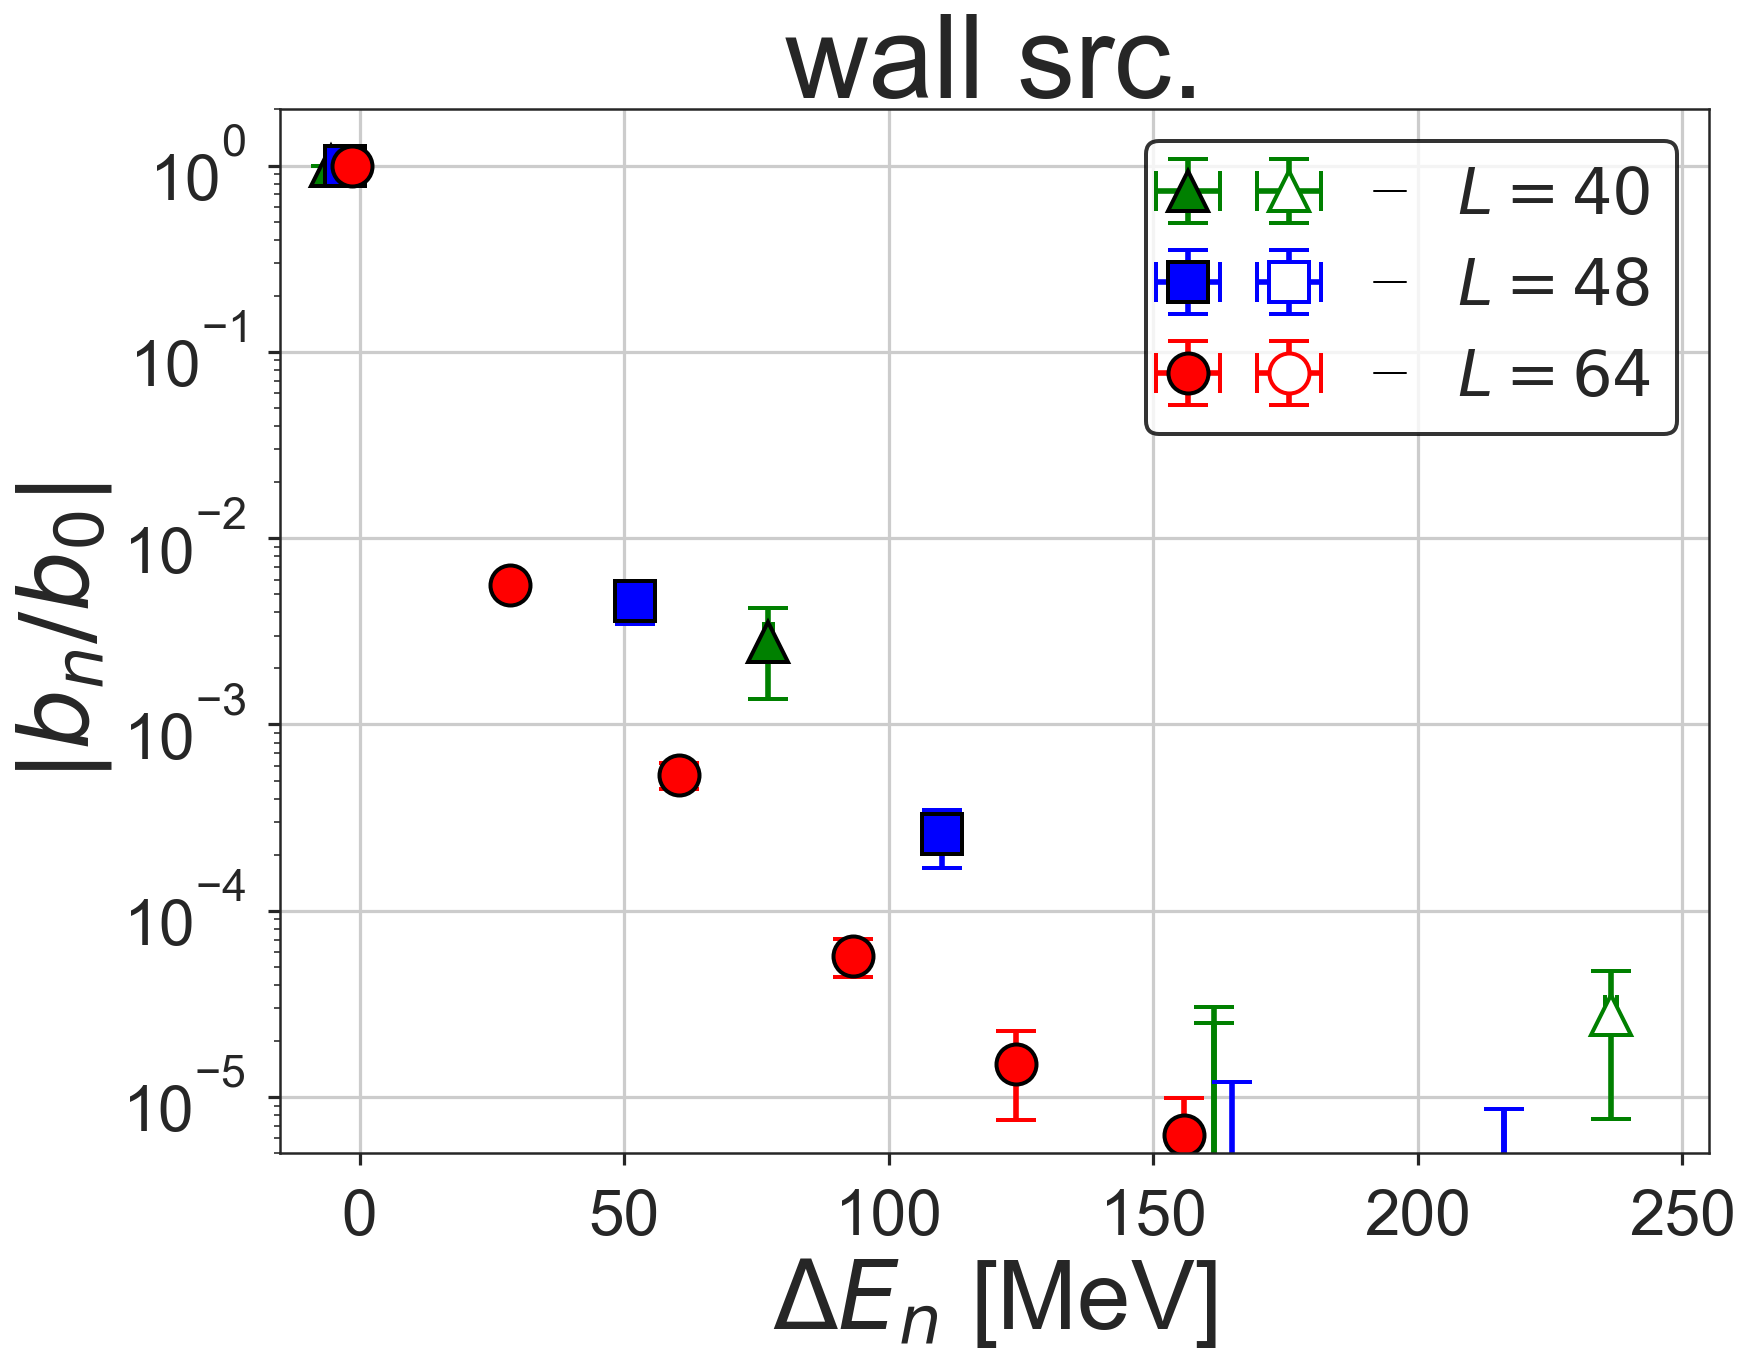

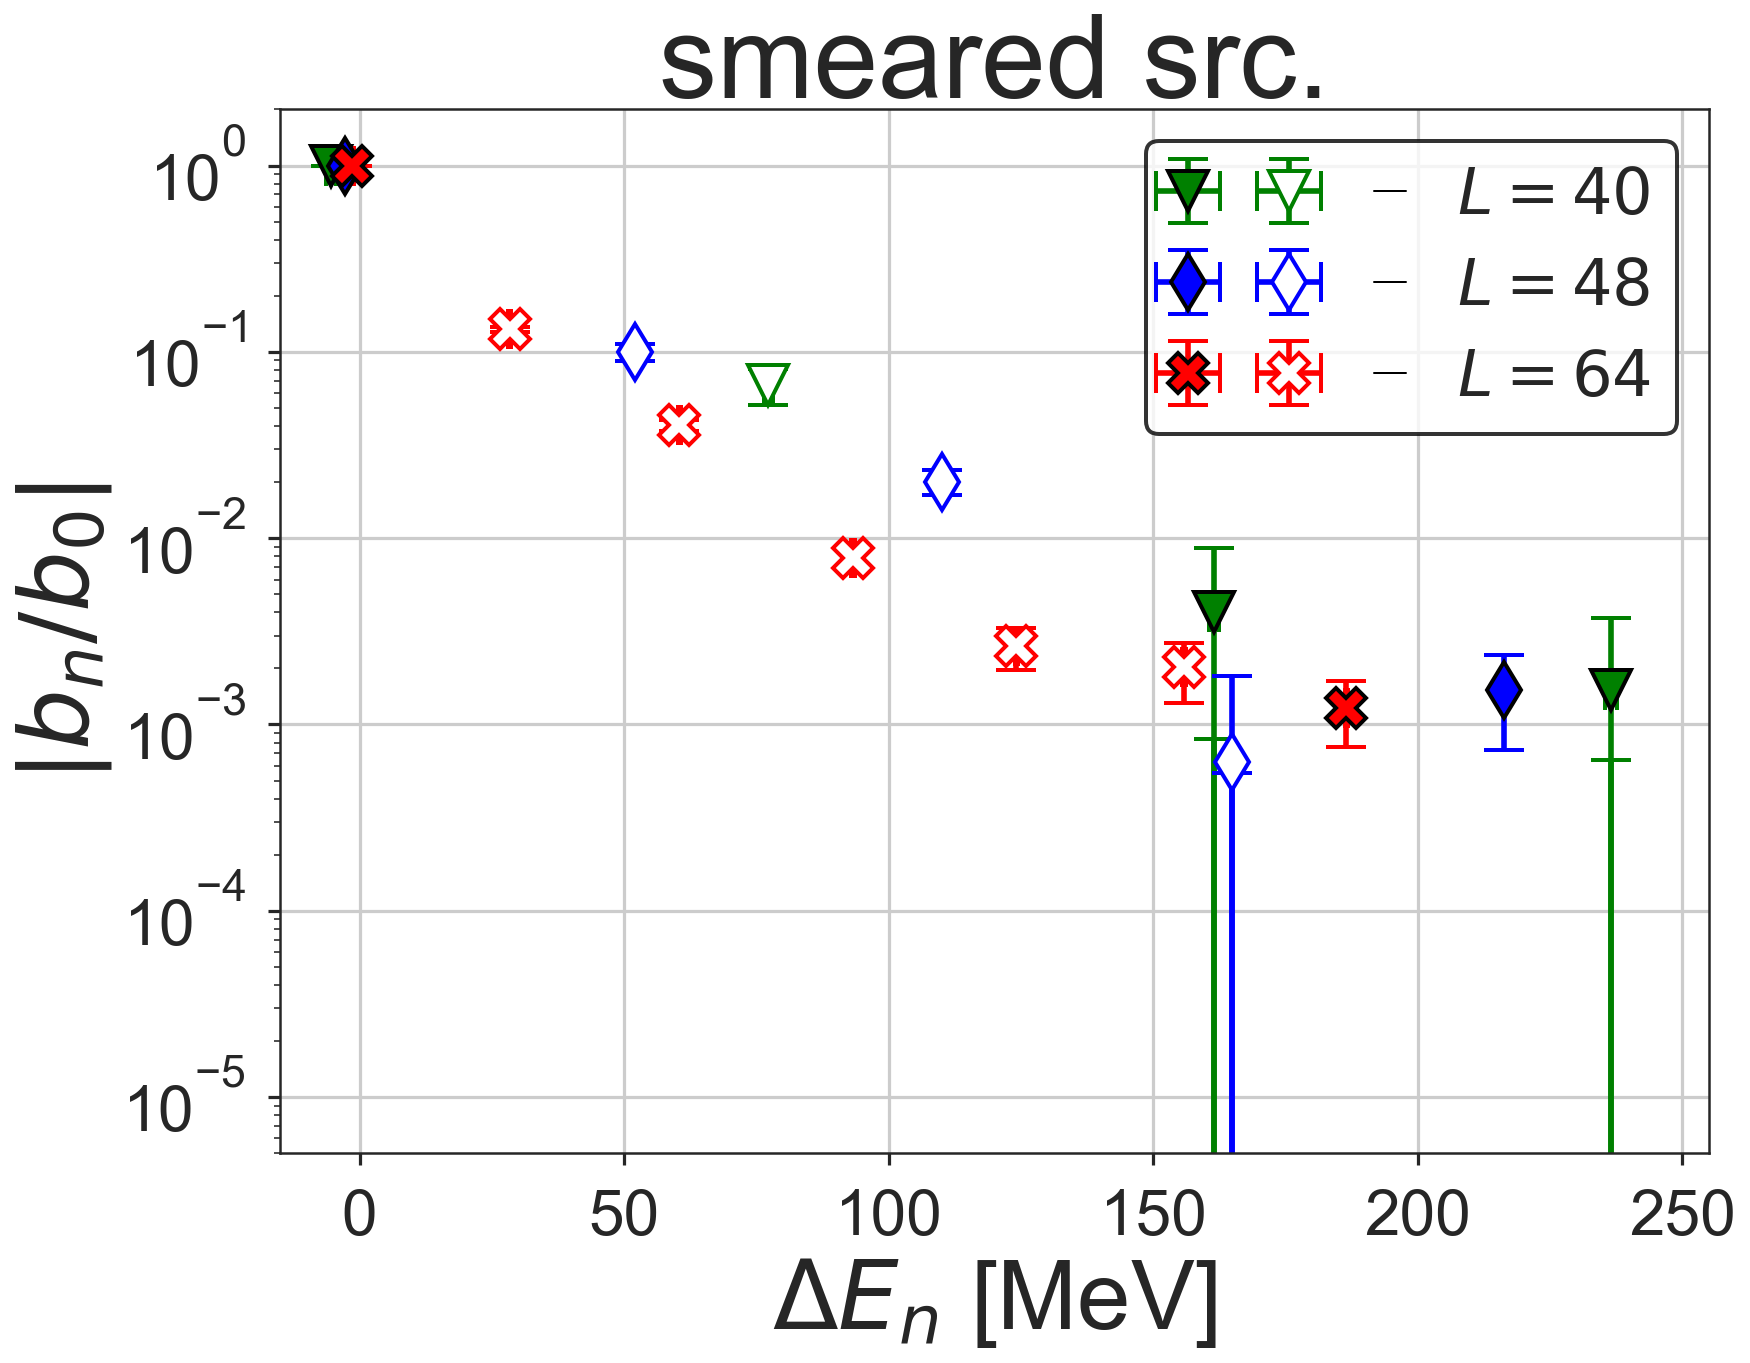

In [39]:
for src in  ['wall', 'exp']:
    for it in [13]:
        fig, ax = plt.subplots()
        syms = {'wall': ['^', 's', 'o'], 'exp': ['v', 'd', 'X']}[src]
        colors = ['green', 'blue', 'red']
        for L, fmt, col in zip([40, 48, 64], syms, colors):
            bn = bn_jk[(src,L,it)]
            bn_b0 = bn[:,:]/bn[0,:]
            ax.plot(np.nan, np.nan, label=r'$L = {}$'.format(L), color='black', lw=1)
            ax.errorbar(eigenval_avs[it][L]*ainv, bn_b0.mean(axis=1), bn_b0.std(axis=1) * np.sqrt(bin_num - 1),
                       xerr=eigenval_errs[it][L]*ainv, fmt=fmt, ms=20, color=col, mew=2.0, mec='black',
                        capthick=2.0, capsize=10,
                       label=r' ')
            ax.errorbar(eigenval_avs[it][L]*ainv, -bn_b0.mean(axis=1), bn_b0.std(axis=1) * np.sqrt(bin_num - 1),
                       xerr=eigenval_errs[it][L]*ainv, fmt=fmt, ms=20, color=col, mew=2.0, mec=col,
                        capthick=2.0, capsize=10, mfc='white',
                       label=r' ')

        hh, ll = ax.get_legend_handles_labels()
        hh = [hh[i] for i in [3, 5, 7, 4, 6, 8, 0, 1, 2]]
        ll = [ll[i] for i in [3, 5, 7, 4, 6, 8, 0, 1, 2]]
        leg = ax.legend(hh, ll, ncol=3, frameon=True, handlelength=0.5, labelspacing=None, columnspacing=0)
        leg.get_frame().set_edgecolor('black')
        leg.get_frame().set_linewidth(2.0)
        ax.set_xlabel(r'$\Delta E_n$ [MeV]', size=48)
        ax.set_ylabel(r'$|b_n/b_0|$', size=48)
        ax.set_yscale('log')
        ax.set_xlim(-15, 255)
        ax.set_ylim(5.0e-6, 2)
        ax.set_title({'wall': 'wall src.', 'exp':'smeared src.'}[src], size=58)
        fig.savefig('../figs/factors/bn_b0_{}_t{:03d}.pdf'.format(src, it), bbox_inches='tight')

check the goodness of the reconstruction of the R-corr.
\begin{equation}
\overline{R}(r,t) = \sum a_n \Psi_n(r) e^{-\Delta E_n}
\end{equation}
and evaluate the residual norm
\begin{equation}
\frac{\sum |R - \overline{R}|^2}{\sum |R|^2}
\end{equation}

(7.55+/-6.34)e-06
(3.65+/-0.33)e-03
(2.63+/-1.50)e-06
(1.64+/-0.07)e-02
(9.82+/-4.77)e-07
(5.14+/-0.07)e-02


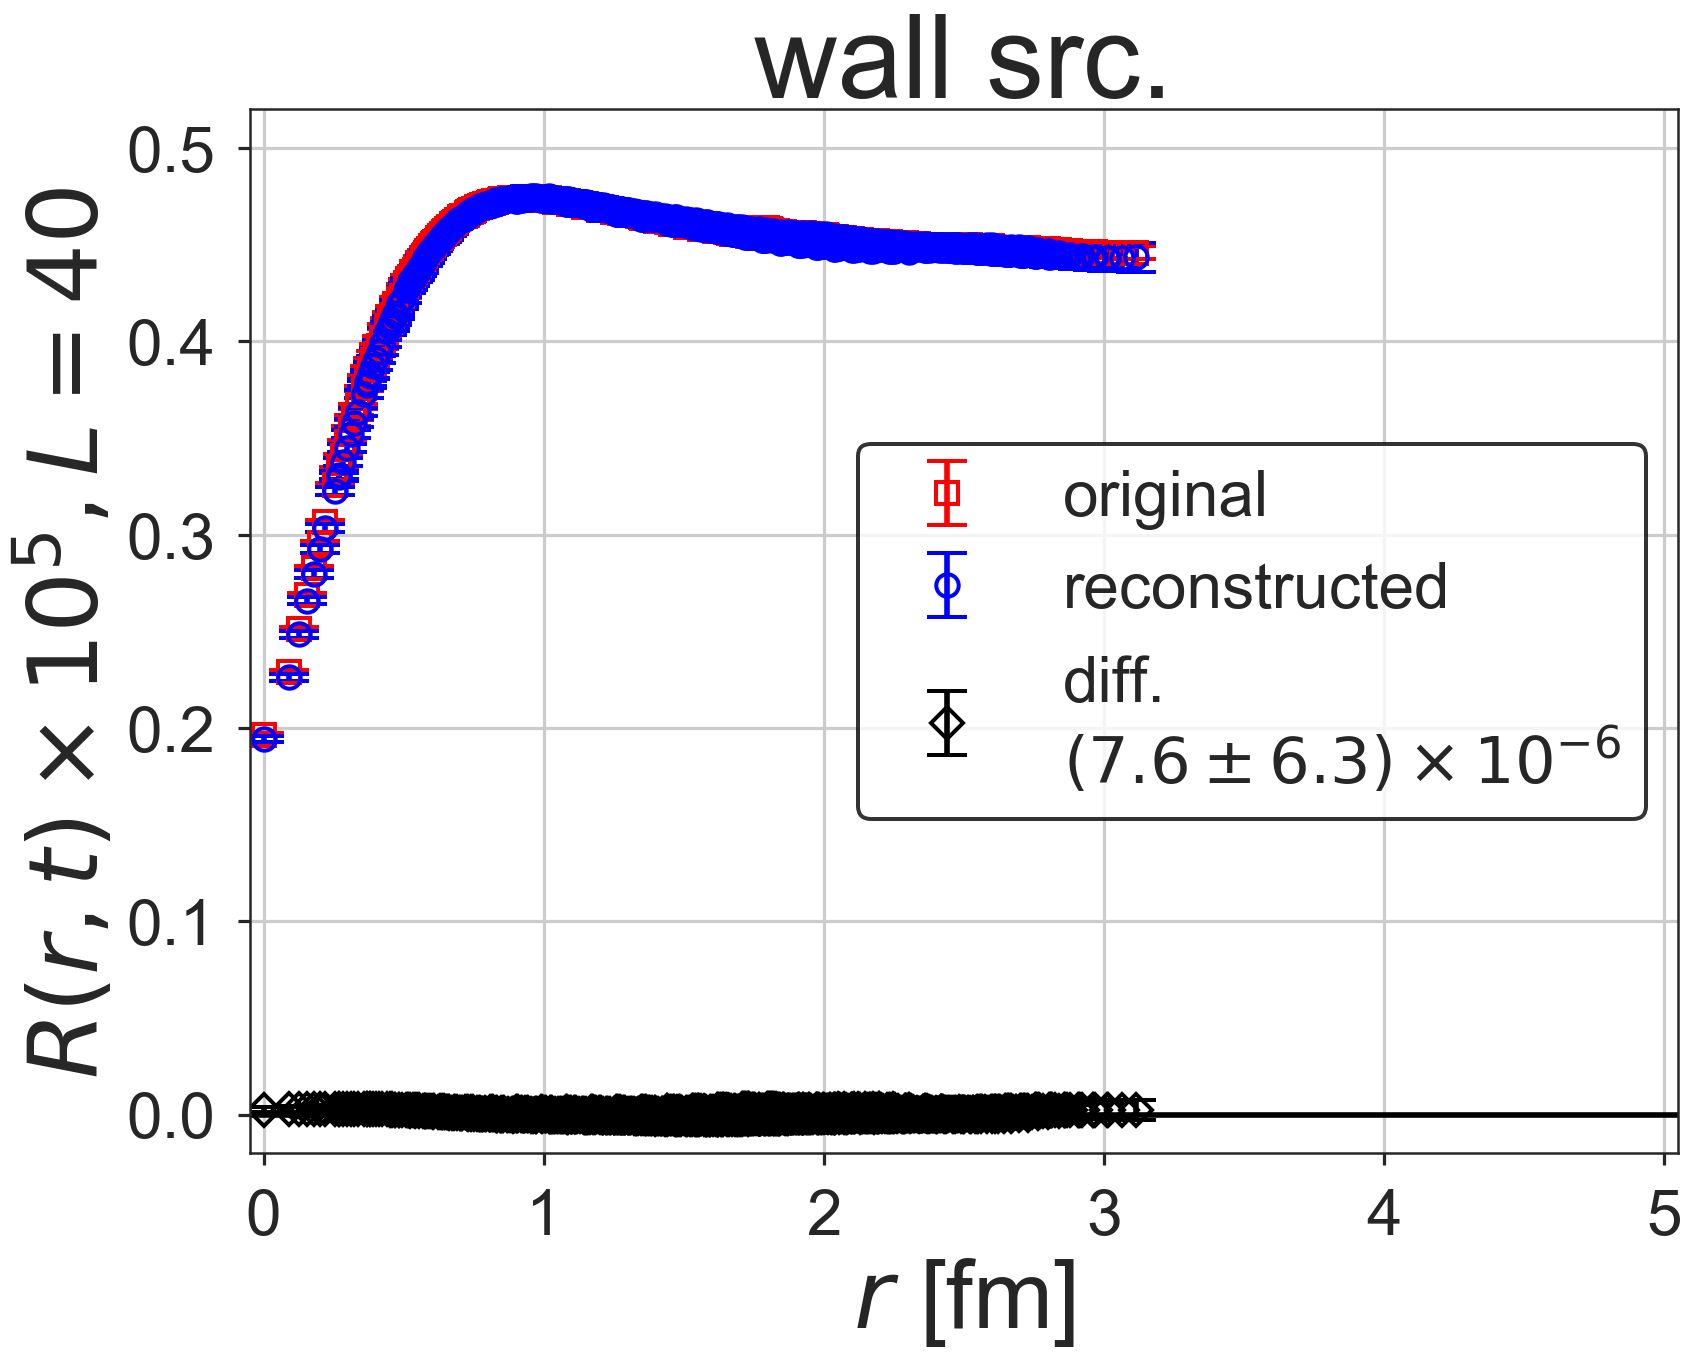

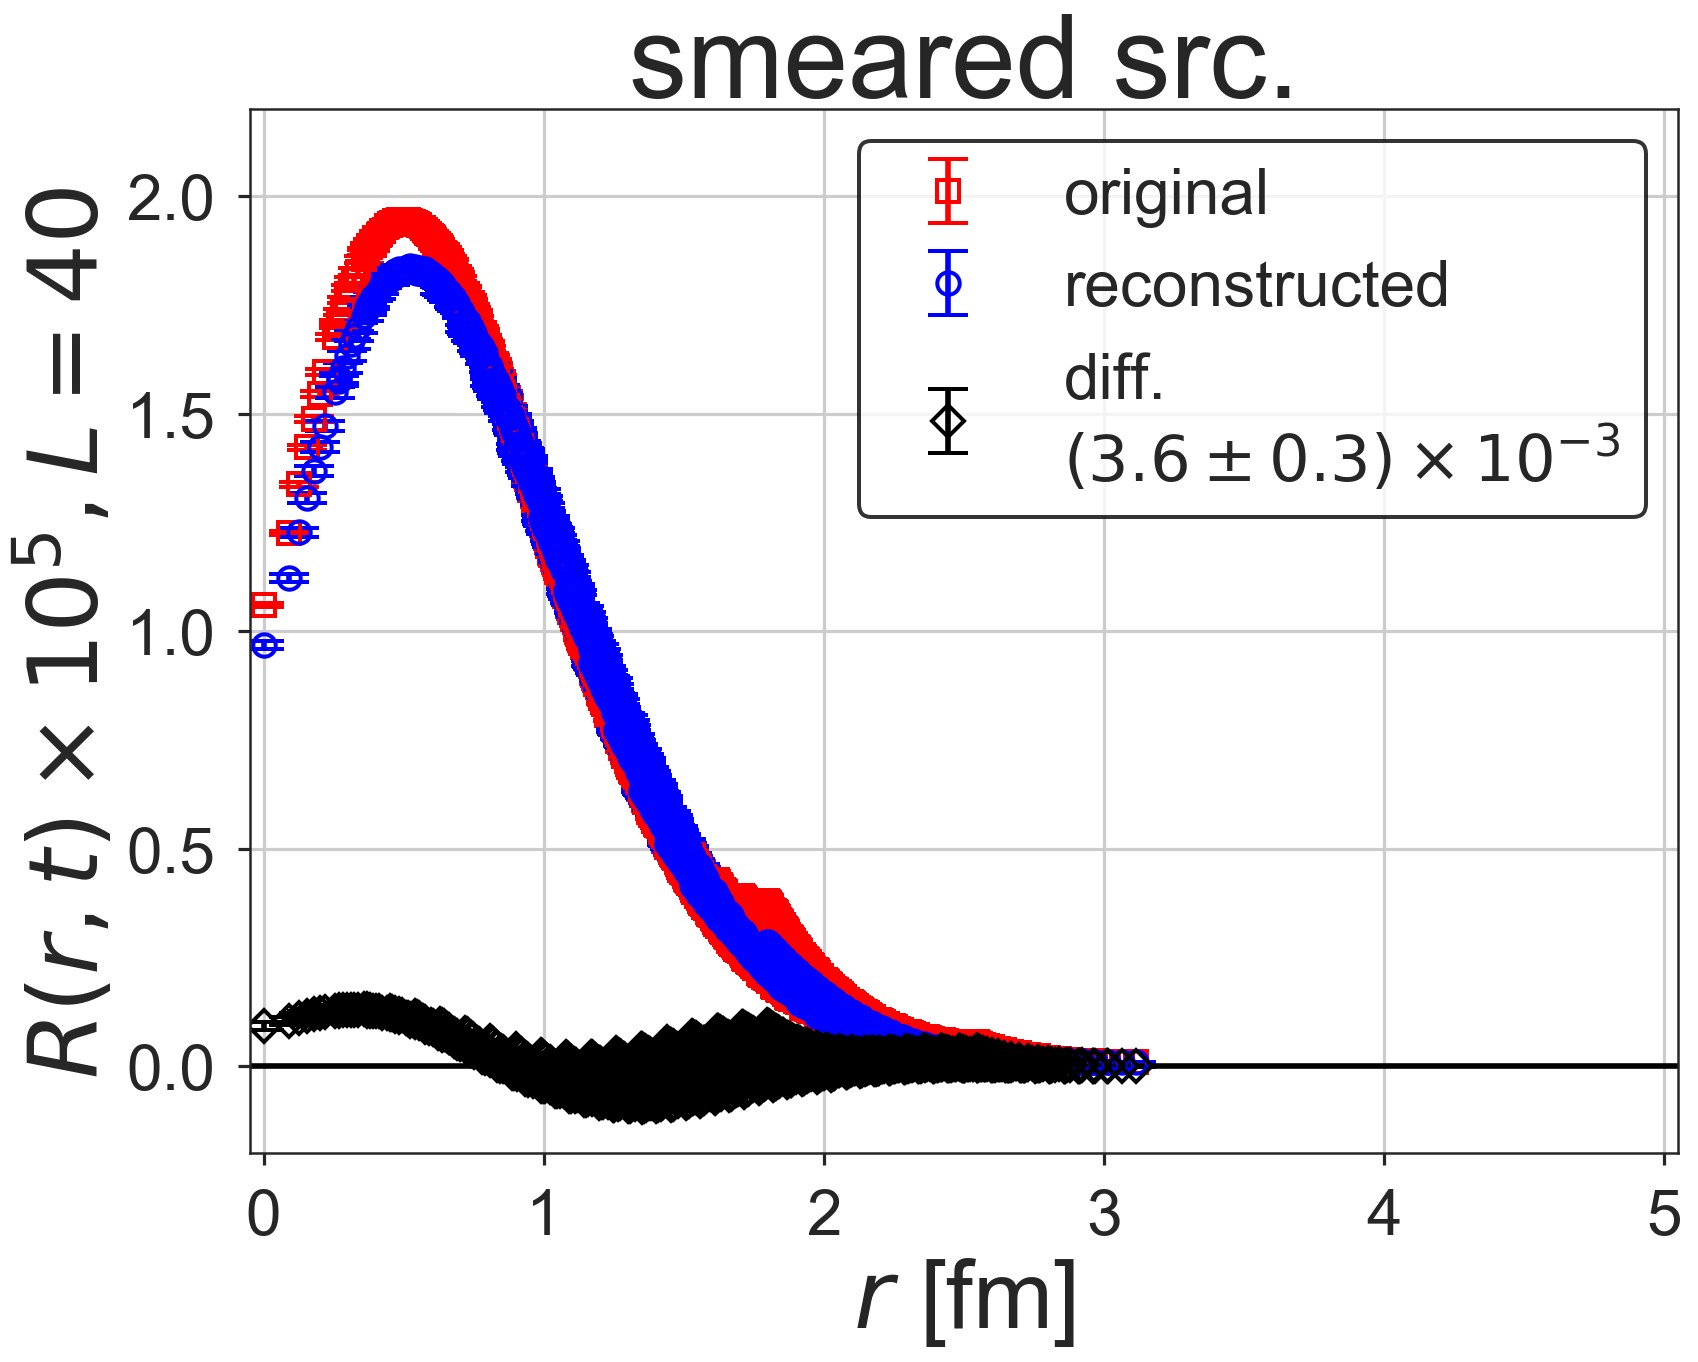

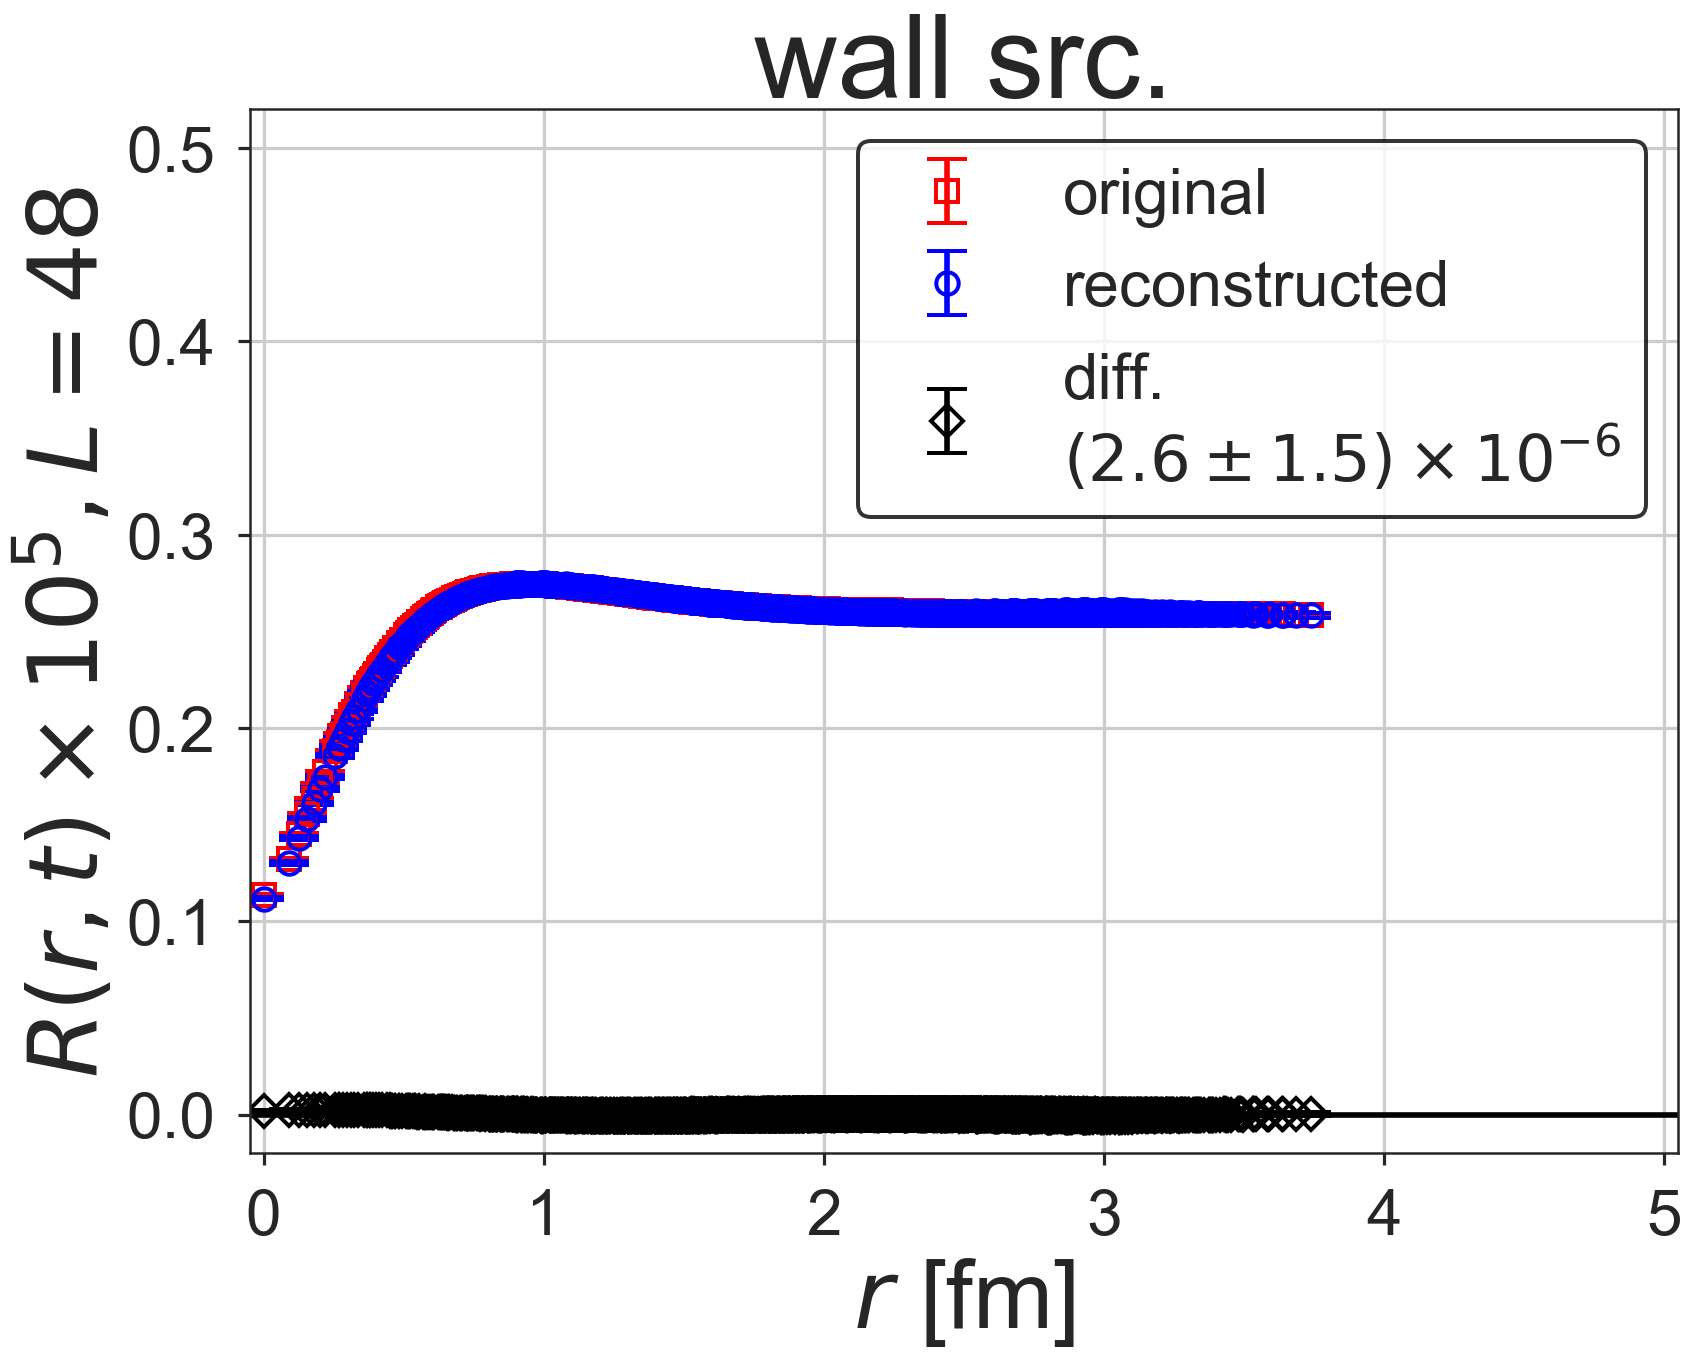

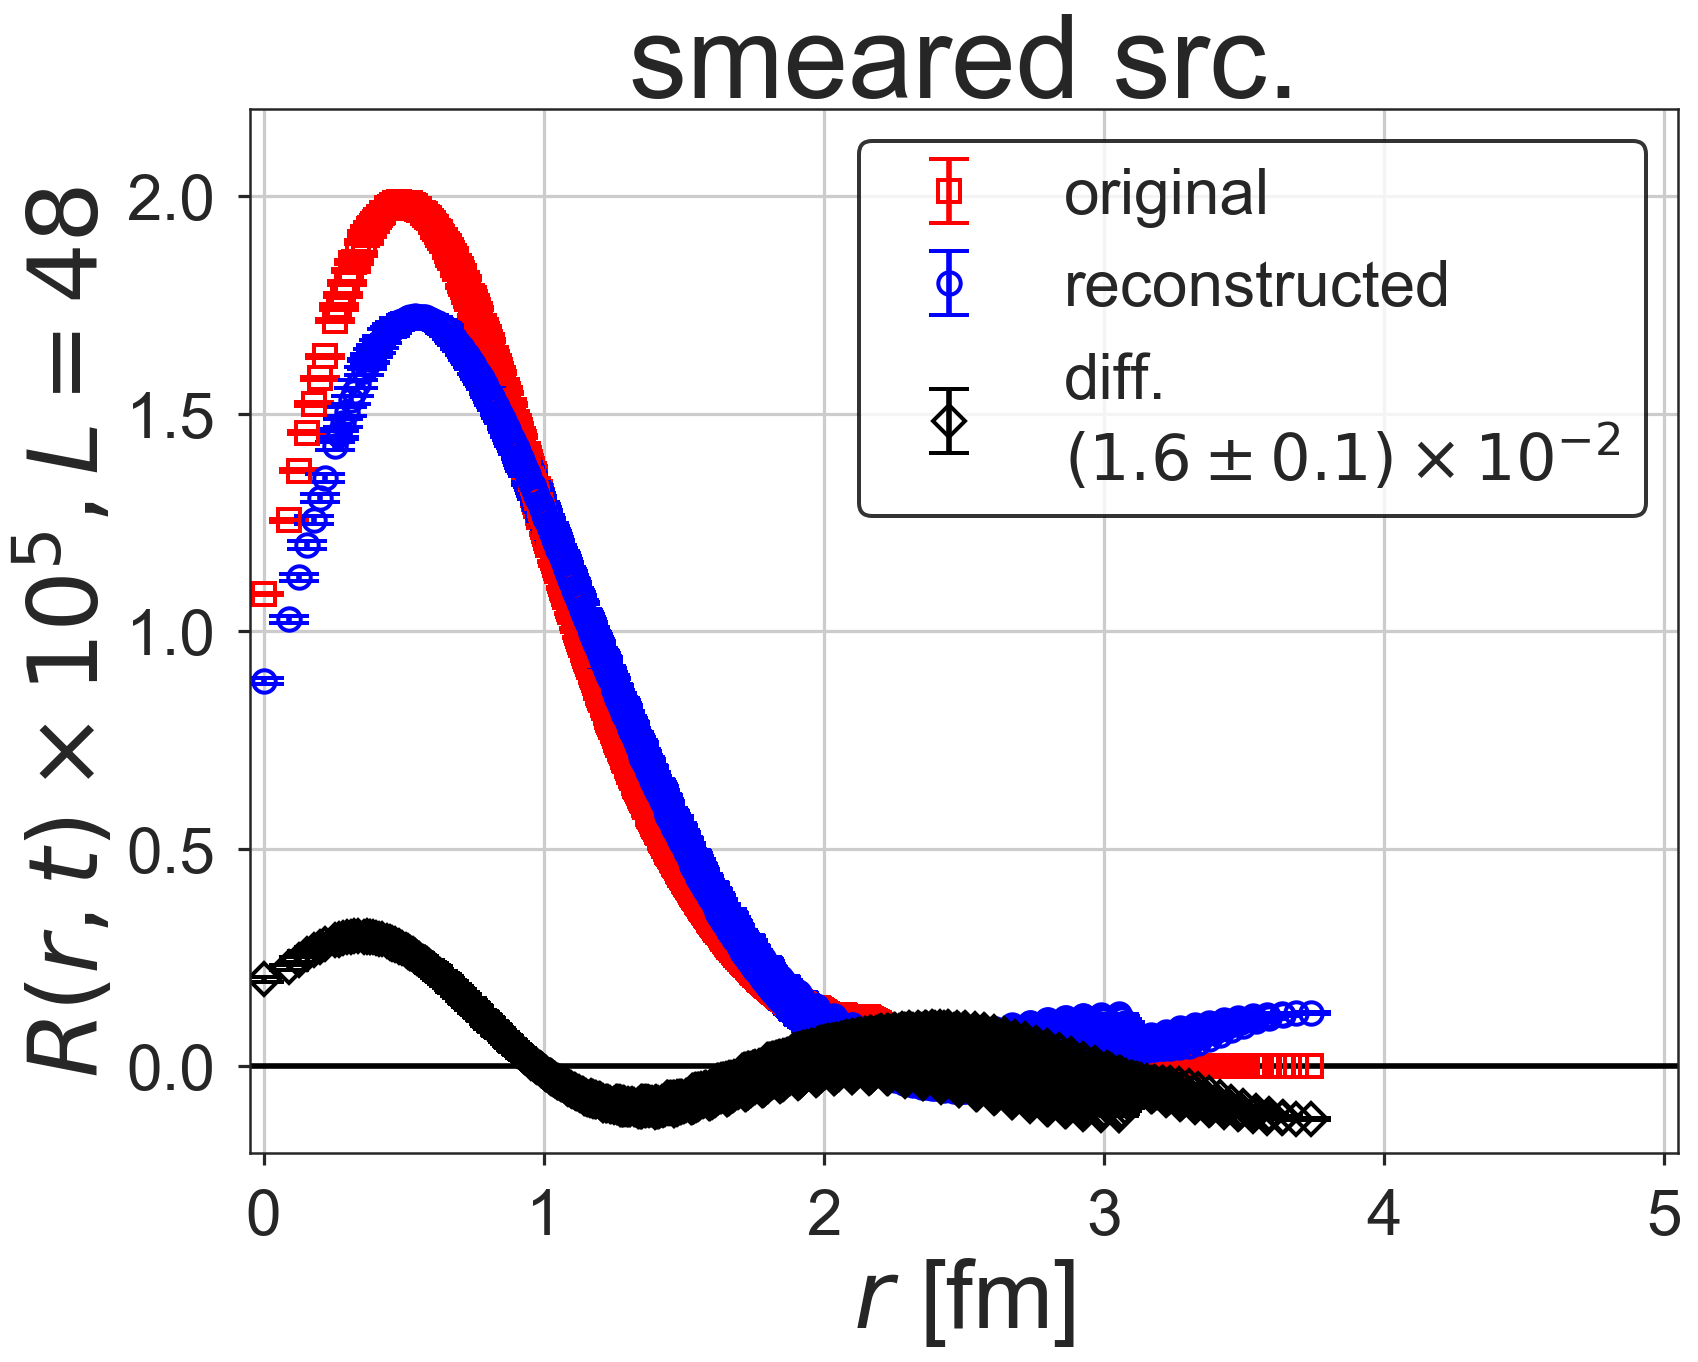

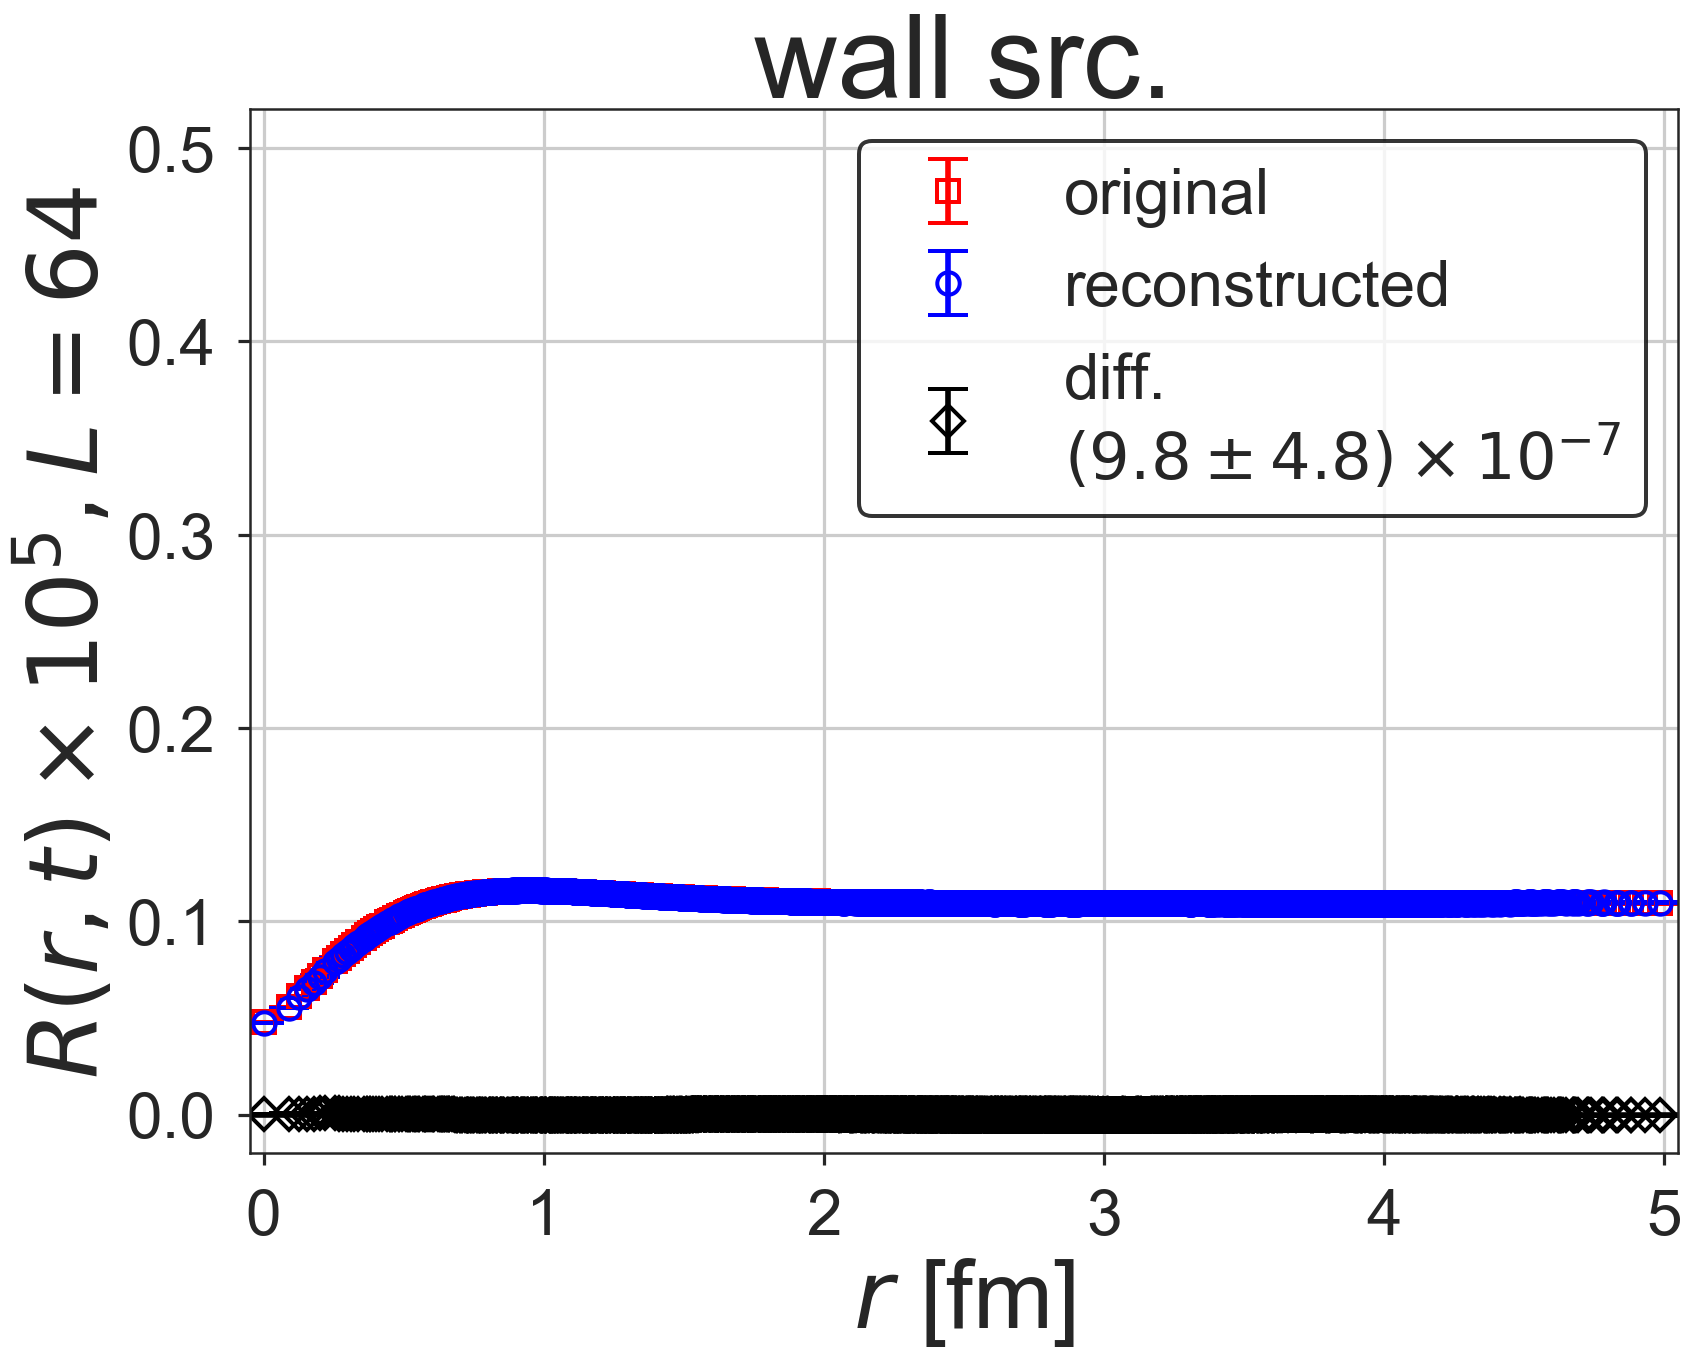

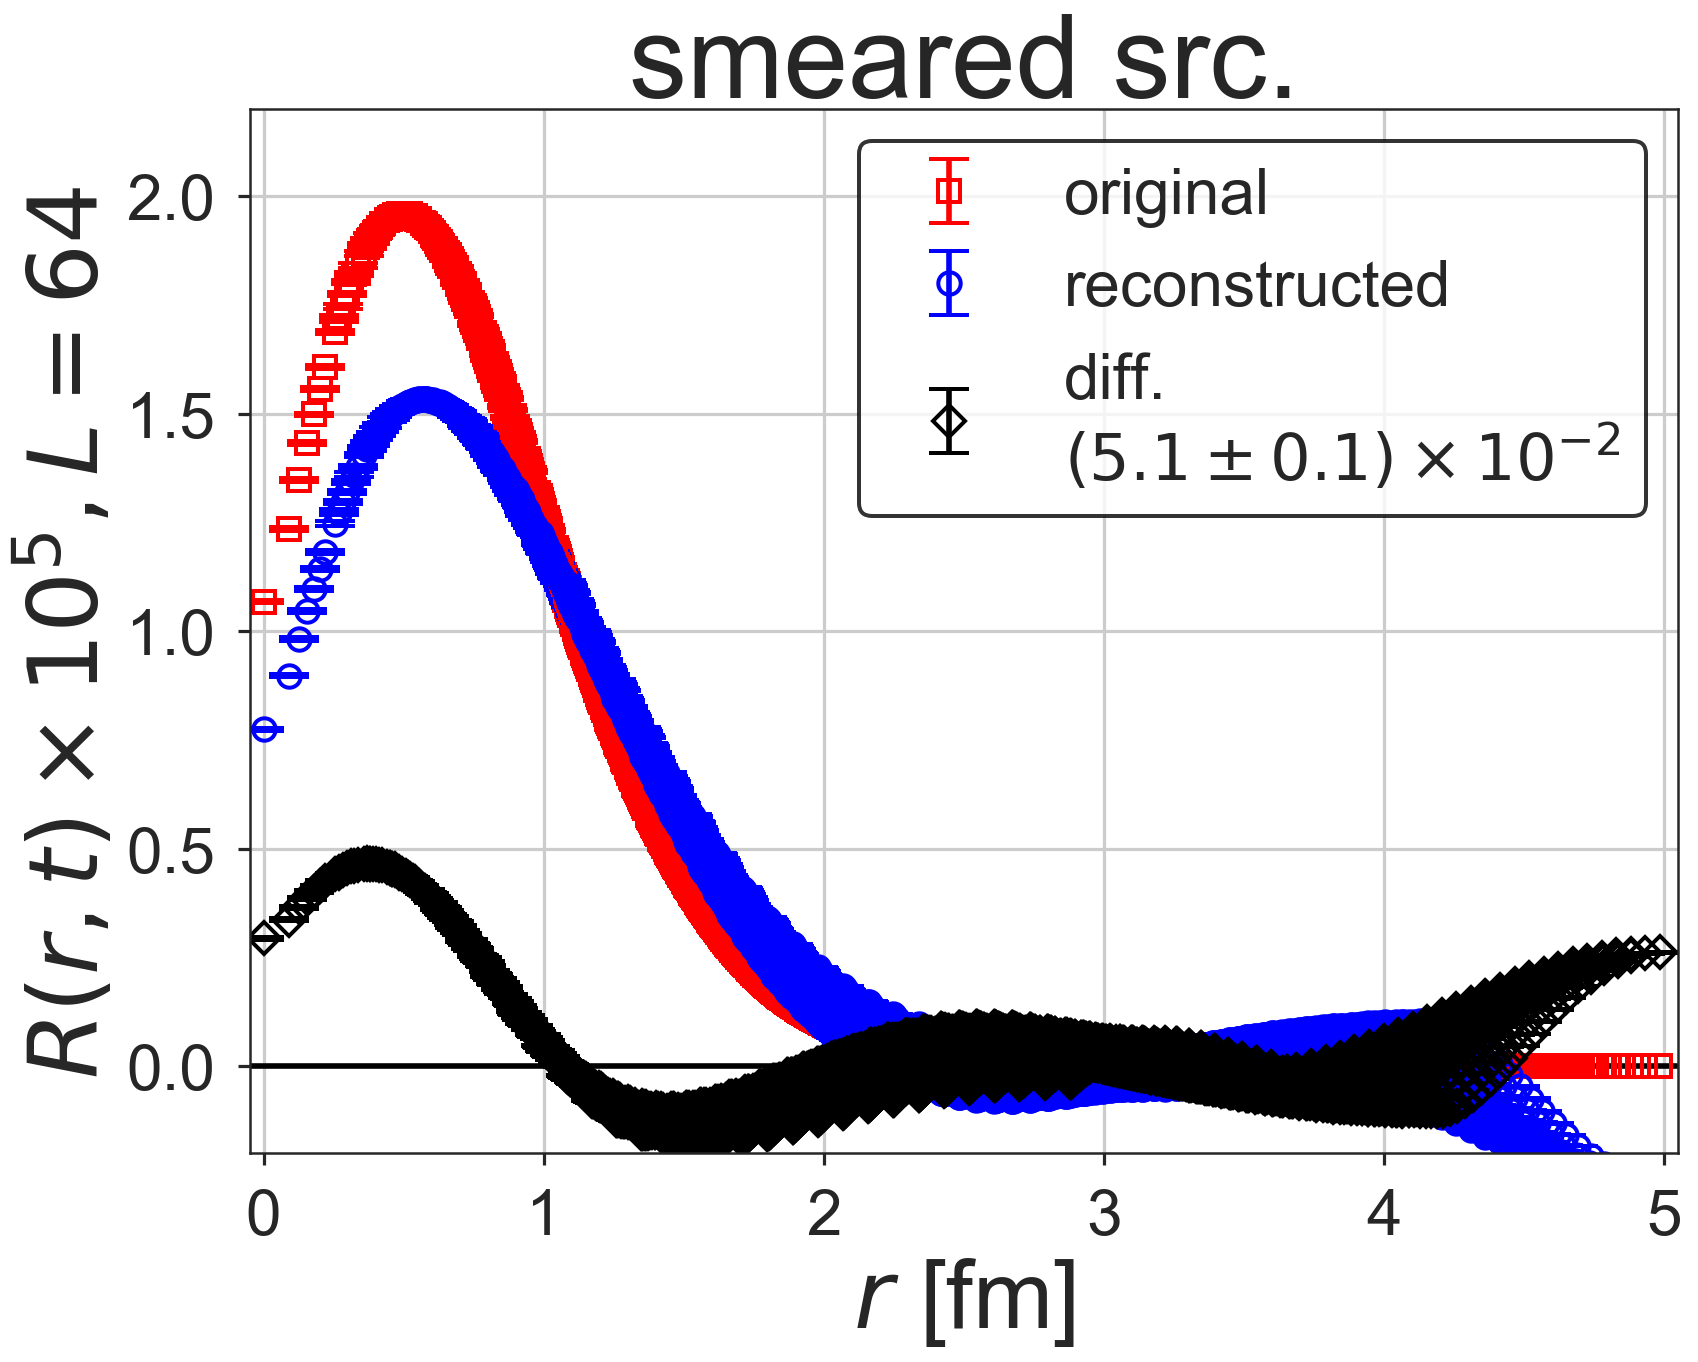

In [40]:
def diff_of_reconst(L,src,it0=13):
    _vec = eigenfuncs[(L,it0)]
    _val = eigenvals[(L,it0)]
    _an = an_jk[(src,L,it0)]
    _Rcorr_jk = Rcorr_jk[(src,L,it0)]
    _rs = rs_[L]
    _uniq = uniq_a1_[L]
    max_num = {40: 4, 48:5, 64:6}[L]
    fac = {'wall': 1.0e5, 'exp': 1.0e5}[src]
    ReRcorr_jk = []
    for ibin in range(_vec.shape[0]):
        _ReRcorr = np.array([_vec[ibin,:,nth] * _an[nth,ibin] * np.exp(-_val[ibin,nth]*it0)
                            for nth in range(max_num)])
        ReRcorr_jk.append(_ReRcorr.sum(axis=0))

    ReRcorr_jk = np.array(ReRcorr_jk)
    fig, ax = plt.subplots()
    ax.errorbar(_rs[_uniq]*lat_unit,
                _Rcorr_jk.mean(axis=0)[_uniq]*fac, 
                _Rcorr_jk.std(axis=0)[_uniq]*np.sqrt(bin_num - 1)*fac,
                fmt='rs', label='original', mfc='none', mew=2.0, mec='red', capsize=10, capthick=2.0)
    ax.errorbar(_rs[_uniq]*lat_unit,
                ReRcorr_jk.mean(axis=0)[_uniq]*fac,
               ReRcorr_jk.std(axis=0)[_uniq]*np.sqrt(bin_num - 1)*fac,
               fmt='o', color='blue', mfc='none', capsize=10, capthick=2.0,
               mew=2.0, mec='blue', label=r'reconstructed')
    Rdiff_jk = np.array([
                (_Rcorr_jk[ibin,:] - ReRcorr_jk[ibin,:])
        for ibin in range(bin_num)])

    diff_val_jk = (Rdiff_jk**2).sum(axis=1)/(_Rcorr_jk**2).sum(axis=1)
    residual = ufloat(diff_val_jk.mean(), diff_val_jk.std()*np.sqrt(bin_num - 1))
    print('{:.2e}'.format(residual))
    #ax.plot([], [], label=r'res. $= {:.1eL}$'.format(residual))
    ax.errorbar(_rs[_uniq]*lat_unit,
                Rdiff_jk.mean(axis=0)[_uniq]*fac,
                Rdiff_jk.std(axis=0)[_uniq]*np.sqrt(bin_num - 1)*fac,
                fmt='D', color='black', mec='black', mfc='none', mew=2.0, 
                capsize=10, capthick=2.0,
                label='diff.' + '\n' + r'${:.1eL}$'.format(residual))
    ax.axhline(0, color='black')
    ax.set_xlim(-0.05, 5.05)

    if src == 'exp':
        ax.set_ylim(-0.2, 2.2)
    elif src == 'wall':
        ax.set_ylim(-0.02, 0.52)
    ax.set_xlabel(r'$r$ [fm]', size=48)
    ax.set_ylabel(r'$R(r,t) \times 10^{}, L = {}$'.format(int(np.log10(fac)), L),size=48)
    ax.set_title({'wall': 'wall src.', 'exp': 'smeared src.'}[src], size=58)
    leg = ax.legend(frameon=True)
    leg.get_frame().set_edgecolor('black')
    leg.get_frame().set_linewidth(2.0)
    fig.savefig('../figs/factors/ReR_check_{}_L{}_t{:03d}.png'.format(src,L,it0),
               bbox_inches='tight')
    
for L in [40, 48, 64]:
    for src in ['wall', 'exp']:
        diff_of_reconst(L, src)